# Homework 03 - Interactive Viz

In [2]:
import os
import pandas as pd
import json
import folium
import copy
from itertools import chain
import numpy as np
%matplotlib inline

## 1. Unemployment in Europe
We use the unemployment dataset downloaded from the [eurostat](http://ec.europa.eu/eurostat/data/database) website, which represents people aged between 15 and 74 years. This dataset reveals the unemployment figures across various countries in Europe, grouped by year and gender. In this analysis, we adopt the most recent data (from 2016) and select the totals (male+female).

***TODO: specify the definition of unemployment according to this dataset***

In [3]:
# Load the data that contains the unemployement statistics in Europe
europe_unemploy_rate_path = 'datasets/europe_unemploy_ratio.csv'
europe_unemploy_rate = pd.read_csv(europe_unemploy_rate_path)

# Select only the totals from the most recent year (2016)
europe_unemploy_rate = europe_unemploy_rate.loc[\
    (europe_unemploy_rate.TIME==2016) & (europe_unemploy_rate.SEX=="Total") & (~europe_unemploy_rate.GEO.str.contains("European|Euro")), \
    ["GEO","Value"]]

# Since we need to merge this data with the TopoJSON data, we have to make sure that the country names are matched
europe_unemploy_rate.loc[europe_unemploy_rate.GEO.str.contains("Germany"), "GEO"] = "Germany"
europe_unemploy_rate.loc[europe_unemploy_rate.GEO.str.contains("Macedonia"), "GEO"] = "The former Yugoslav Republic of Macedonia"

print("The unemployment rate is available for", europe_unemploy_rate.shape[0], "states")
europe_unemploy_rate

The unemployment rate is available for 33 states


,GEO,Value
1071,Belgium,7.8
1074,Bulgaria,7.6
1077,Czech Republic,4.0
1080,Denmark,6.2
1083,Germany,4.1
1086,Estonia,6.8
1089,Ireland,7.9
1092,Greece,23.6
1095,Spain,19.6
1098,France,10.1


We draw the boundaries of the following states:

In [9]:
# Load the TopoJSON description of Europe, that defines the shape of the states
europe_topo_path = 'topojson/europe.topojson.json'
topo_data = json.load(open(europe_topo_path))
topo_states = [state["properties"]["NAME"] for state in topo_data["objects"]["europe"]["geometries"]]
print(len(topo_states), "states:", ", ".join(topo_states))

51 states: Azerbaijan, Albania, Armenia, Bosnia and Herzegovina, Bulgaria, Cyprus, Denmark, Ireland, Estonia, Austria, Czech Republic, Finland, France, Georgia, Germany, Greece, Croatia, Hungary, Iceland, Israel, Italy, Latvia, Belarus, Lithuania, Slovakia, Liechtenstein, The former Yugoslav Republic of Macedonia, Malta, Belgium, Faroe Islands, Andorra, Luxembourg, Monaco, Montenegro, Netherlands, Norway, Poland, Portugal, Romania, Republic of Moldova, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, Ukraine, San Marino, Serbia, Holy See (Vatican City), Russia


In [11]:
# The unemployment figures are not available for all states
missing_states = list(set(topo_states)-set(europe_unemploy_rate.GEO))
print("The unemployement rate of these", len(missing_states), "states is missing:", ", ".join(missing_states))

The unemployement rate of these 18 states is missing: Holy See (Vatican City), Belarus, Georgia, Azerbaijan, Liechtenstein, Russia, Andorra, Serbia, San Marino, Faroe Islands, Montenegro, Bosnia and Herzegovina, Republic of Moldova, Albania, Monaco, Armenia, Israel, Ukraine


We now plot an interactive Cloropleth map that shows the unemployment rate in European states. By clicking on a state, it is possible to see the detailed information.

In [130]:
def fill_invalid(state):
    '''
    This helper function is used for highlighting the states for which there is no information about unemployment.
    '''
    if state in list(missing_states):
        return 0.7
    else:
        return 0

The interactive map is built as follows:
- First, we use the built-in method *"cloropleth"* in the Folium library for displaying the map and coloring every state.
- Interactivity is added by inserting TopoJSON elements that isolate individual countries. Afterwards, we attach a different *Popup* element to each of these elements. This approach, if used as-is, causes some problems when the map is rendered. It seems that Folium copies the entire TopoJSON dataset each time a new element is added, thereby generating a huge amount of HTML code (about 12 MB), which cannot be rendered on the notebook. We solved this problem by writing the helper function *optimize*, which removes unused information inside a TopoJSON datset (we will call this function for each country).

In [131]:
def optimize(data):
    '''
    This helper function is used for removing unused arcs from a TopoJSON dataset,
    thus reducing the size of the resulting HTML code.
    '''
    used_arcs = set()
    for o in data['objects']:
        for geom in data['objects'][o]['geometries']:
            if geom['type'] == 'MultiPolygon':
                it = chain.from_iterable(geom['arcs'])
            else:
                it = geom['arcs']

            for i in chain.from_iterable(it):
                used_arcs.add(i if i >= 0 else ~i)
    for i in range(len(data['arcs'])):
        if i not in used_arcs:
            data['arcs'][i] = [] # Erase arc data
    return data

In [132]:
europe_location = [55, 15]

m = folium.Map(location=europe_location, zoom_start=3)

# Build a Cloropleth map that represents the unemployment rate of each state
m.choropleth(
    geo_data=topo_data, 
    topojson='objects.europe',
    data=europe_unemploy_rate,
    columns=['GEO', 'Value'],
    key_on='properties.NAME',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    legend_name='Percentage of unemployement (%)')

# Fill with gray the states for which we have no information,
# and add a popup to every state that shows detailed information
for state in topo_data["objects"]["europe"]["geometries"]:
    state_name = state["properties"]["NAME"]
    unemp_rate = europe_unemploy_rate.Value[europe_unemploy_rate.GEO == state_name]
    if unemp_rate.size == 0:
        unemp_rate = "not available"
    else:
        unemp_rate = "{0:.1f}".format(unemp_rate.iloc[0]) + " %"

    popup_content  = '<h4>' + state["properties"]["NAME"] + '</h4>'
    popup_content += '<span style="font-weight:bold">Unemployment rate: </span>' + unemp_rate
        
    tdata = copy.deepcopy(topo_data)
    tdata['objects']['europe']['geometries'] = [state]
    folium.TopoJson(
        optimize(tdata),
        'objects.europe',
        name=state['id'],
        style_function=lambda geometry: {
                # States without unemployment information are filled with grey
                'fillColor': "#424949", 
                'fillOpacity': fill_invalid(geometry["properties"]["NAME"])
            }
    ).add_child(folium.Popup(popup_content)).add_to(m)

m

# TODO
- Discuss colors used (or which color palette we used)
- Discuss interval splitting (or which algorithm has been used if automatic)
- Compare Switzerland's unemployment rate to that of the rest of Europe (maybe show list of countries ordered by unemployment rate).

## 2-3. Unemployment in Switzerland
The amstat website provides information in the three national languages of Switzerland (German, French, Italian), but not in English. Being Italian speakers, we adopted this language and translated to English wherever possible.

Important definitions (from https://www.amstat.ch/v2/definition.jsp?lang=it):
- The unemployement rate is defined as **# unemployed people / # active people**, where **unemployed people** are those who are looking for a job without having one already. 
- The exact definition of **unemployed people** is *"Numero dei disoccupati registrati, nel giorno di riferimento (ultimo giorno del mese), diviso per il numero di persone attive, moltiplicato per 100."*, which translates to *"Number of registered unemployed people, in the last day of the month, multiplied by 100"*.
- The exact definition of **active people** is: *"Persone che svolgono un'attività lucrativa di almeno un'ora per settimana e le persone non occupate."*, which translates to *"People engaged in for-profit activities for at least one hour per week, and people without employment"*.

**Problem (for question 3)**: The website does not allow to download the rate of unemployement grouped by age and nationality at the same time (only one indicator is allowed), but only the absolute number of unemployed people divided in such a way. Since we are interested in the rate of unemployment, we need the active population for each category Ci defined as a tuple {Canton, Nationality, Age class} to compute the *unemployment rate * = (number of unemployed people in category Ci)/(active population of category Ci).
**Solution**: If we consider three age classes (15-24, 15-49, 50+), then we are unable to compute the active population for each category Ci since the site does not provide enough information. However, we can retrieve the active population for the people aged 15-24 on a *{Canton, Nationality}* basis. Therefore, we decided to adopt only 2 age classes: 15-24 and 25+. The class 25+ can be computed by subtracting the class 15-24 from the total.

In order to avoid downloading a different dataset for each task, we decided to proceed as follows:
1. Compute the active population of each category:
    - *Active population divided per Canton and Nationality*: we download the dataset with the unemployement rate and the number of unemployed people divided by Canton and Nationality. From this dataset, we compute the active population for every group {Canton, Nationality} as "active population=number of unemployed people*100/ratio of unemployed people".
    - *Active population of people aged 15-24 divided by Canton and Nationality*: this information can be directly downloaded from the website.
    - *Active population of people of age 25+ divided by Canton and Nationality*: this is easily derived from the previous two. 
2. Download the complete dataset with the number of unemployed peopled divided by canton, age class and nationality. We clean this dataset and, as explained before, we consider only the two age classes 15-24 and 25+. Then we transform each number of unemployed people in the ratio of unemployed people using the previously computed active population values.
3. To answer the questions in the assignment, we aggregate on the fields in which we are interested.

In [36]:
# Helper function (integers are in an invalid format)
# Parses a string to an integer, removing invalid characters
def parseInt(numStr):
    cleaned = [x for x in numStr if x.isdigit()]
    return int("".join(cleaned))

In [37]:
def absoluteToRatios(data):
    '''
    Computes ratios from absolute values.
    '''
    act_pop = data["Active Population"]
    data["Jobseekers"] = round(data["Jobseekers"]*100/act_pop, 1)
    data["Unemployed Jobseekers"] = round(data["Unemployed Jobseekers"]*100/act_pop, 1)
    data["Employed Jobseekers"] = round(data["Employed Jobseekers"]*100/act_pop, 1)
    
    # rename the columns
    column_rename = {
        "Jobseekers": "Ratio of Jobseekers",
        "Unemployed Jobseekers": "Ratio of Unemployed Jobseekers",
        "Employed Jobseekers": "Ratio of Employed Jobseekers"
    }
    data.rename(columns=column_rename, inplace=True)
    return data

In [39]:
# Load the Swiss topology data (geometry of the cantons)
ch_topo_path = 'topojson/ch-cantons.topojson.json'
topo_data_ch = json.load(open(ch_topo_path, encoding="utf-8"))
topo_cantons = [state["properties"]["name"] for state in topo_data_ch["objects"]["cantons"]["geometries"]]
print("We draw the boundaries of the following", len(topo_cantons), "cantons:", ", ".join(topo_cantons))

We draw the boundaries of the following 26 cantons: Zürich, Bern/Berne, Luzern, Uri, Schwyz, Obwalden, Nidwalden, Glarus, Zug, Fribourg, Solothurn, Basel-Stadt, Basel-Landschaft, Schaffhausen, Appenzell Ausserrhoden, Appenzell Innerrhoden, St. Gallen, Graubünden/Grigioni, Aargau, Thurgau, Ticino, Vaud, Valais/Wallis, Neuchâtel, Genève, Jura


Load the data regarding the rate of unemployement so as to compute the active population per category.

   - *Active population, grouped by Canton and Nationality*

In [42]:
path = 'datasets/ch_unemploy_rate_bycanton_bynationality.csv'
ch_ap_canton_nationality = pd.read_csv(path)

# 1. drop and rename the columns
column_rename = {
    "Cantone":"Canton", 
    "Nazionalità": "Nationality",
    "Tasso di disoccupazione": "Unemployement rate", 
    "Disoccupati registrati": "Unemployed"
}
ch_ap_canton_nationality = ch_ap_canton_nationality[list(column_rename.keys())]
ch_ap_canton_nationality.rename(columns=column_rename, inplace=True)
ch_ap_canton_nationality = ch_ap_canton_nationality[~(ch_ap_canton_nationality.Canton=="Totale")]

# 2. converto objects to integers
ch_ap_canton_nationality["Unemployed"] = ch_ap_canton_nationality["Unemployed"].apply(parseInt)

# 3. compute the active population
ch_ap_canton_nationality["Active Population"] = \
    (100*ch_ap_canton_nationality["Unemployed"]/ch_ap_canton_nationality["Unemployement rate"]).astype("int")

# 4. translate column Nationality
ch_ap_canton_nationality.Nationality = ch_ap_canton_nationality.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")

# 5. Rename the cantons
ch_ap_canton_nationality["Canton"] = [c for canton in topo_cantons for c in [canton]*2]

ch_ap_canton_nationality = ch_ap_canton_nationality[["Canton", "Nationality", "Active Population"]]
ch_ap_canton_nationality.head(2)

,Canton,Nationality,Active Population
0,Zürich,Foreigners,228509
1,Zürich,Swiss,604560


- *Active population of people aged 15-24, grouped by Canton and Nationality*

In [48]:
path = 'datasets/ch_activepopulation_class1_bynationality.csv'
ch_ap_class1_canton_nationality = pd.read_csv(path)

# 0. Add a column "Age" to indicate that this dataframe is related to people of age 15-24
ch_ap_class1_canton_nationality["Age"] = "15-24"

# 1. Drop useless columns and translate the useful ones from Italian to English
column_rename = {
    "Cantone": "Canton", 
    "Nazionalità": "Nationality",
    "Age": "Age",
    "Persone attive (giovane)": "Active Population"
}
ch_ap_class1_canton_nationality = ch_ap_class1_canton_nationality[list(column_rename.keys())]
ch_ap_class1_canton_nationality.rename(columns=column_rename, inplace=True)

# 2. converto objects to integers
ch_ap_class1_canton_nationality["Active Population"] = ch_ap_class1_canton_nationality["Active Population"].apply(parseInt)

# 4. translate column Nationality
ch_ap_class1_canton_nationality.Nationality = ch_ap_class1_canton_nationality.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")

# 5. Rename the cantons
ch_ap_class1_canton_nationality["Canton"] = [c for canton in topo_cantons for c in [canton]*2]

# We show an example with one canton (Zürich)
ch_ap_class1_canton_nationality.head(2)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,15-24,17384
1,Zürich,Swiss,15-24,74226


- *Active population of people aged 25+, grouped by Canton and Nationality*

In [44]:
ch_ap_class2_canton_nationality = ch_ap_class1_canton_nationality.copy()
ch_ap_class2_canton_nationality["Age"] = "25+"
ch_ap_class2_canton_nationality["Active Population"] = \
    ch_ap_canton_nationality["Active Population"]-ch_ap_class1_canton_nationality["Active Population"]

ch_ap_class2_canton_nationality.head(2)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,25+,211125
1,Zürich,Swiss,25+,530334


Finally, we can merge this information into a single dataframe.

In [47]:
active_population = pd.concat((ch_ap_class1_canton_nationality, ch_ap_class2_canton_nationality))
active_population.sort_values(['Canton', 'Nationality']).tail(4)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,15-24,17384
0,Zürich,Foreigners,25+,211125
1,Zürich,Swiss,15-24,74226
1,Zürich,Swiss,25+,530334


Now that we have the active population values, we can collect all the information so that it will be possible to compute the ratios that we need for the following tasks.

In [49]:
path = 'datasets/ch_unemploed_bycanton_byage_bynationality.csv'
ch_unemployed = pd.read_csv(path)
# Dataset cleaning steps:

# 1. Drop useless columns and translate the useful ones from Italian to English
column_rename = {
    "Cantone": "Canton",
    "Nazionalità": "Nationality",
    "Classi d'età 15-24, 15-49, 50 anni e più": "Age",     
    "Persone in cerca d'impiego": "Jobseekers",
    "Disoccupati registrati": "Unemployed Jobseekers",
    "Persone in cerca d'impiego non disoccupate": "Employed Jobseekers"
}
ch_unemployed = ch_unemployed[list(column_rename.keys())]
ch_unemployed.rename(columns=column_rename, inplace=True)

# 2. Drop totals
ch_unemployed = ch_unemployed[~(ch_unemployed=="Totale").any(axis=1)]

# 3. Translate canton name and nationality from Italian to English
canton_names = [name for canton in topo_data_ch['objects']['cantons']["geometries"] for name in [canton["properties"]["name"]]*6]
ch_unemployed.Canton = canton_names
ch_unemployed.Nationality = ch_unemployed.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")  

# 4. Convert objects to integers
ch_unemployed["Jobseekers"] = ch_unemployed["Jobseekers"].apply(parseInt)
ch_unemployed["Unemployed Jobseekers"] = ch_unemployed["Unemployed Jobseekers"].apply(parseInt)
ch_unemployed["Employed Jobseekers"] = ch_unemployed["Employed Jobseekers"].apply(parseInt)

# 5. Merge the age classes to the two that we adopted (i.e. 15-24 and 25+)
ch_unemployed.Age = ch_unemployed.Age.astype("int")
ch_unemployed.Age = ch_unemployed.Age.apply(lambda class_: "15-24" if class_==1 else "25+")
ch_unemployed = ch_unemployed.groupby(by=["Canton", "Nationality", "Age"]).sum().reset_index()

# 6. Add column with active population
ch_unemployed = pd.merge(ch_unemployed, active_population, on=["Canton", "Nationality", "Age"], how='left')

ch_unemployed.sort_values(by=["Canton", "Nationality", "Age"])
ch_unemployed.tail(4)

,Canton,Nationality,Age,Jobseekers,Unemployed Jobseekers,Employed Jobseekers,Active Population
100,Zürich,Foreigners,15-24,1178,1015,163,17384
101,Zürich,Foreigners,25+,14206,11096,3110,211125
102,Zürich,Swiss,15-24,2671,2405,266,74226
103,Zürich,Swiss,25+,16101,12709,3392,530334


On the obtained DataFrame, we aggregate on the fields in which we are interested so as to compute the respective rates of unemployed people.

#### We answer the questions by grouping on the fields in which we interested.

- **question 2**: ... "unemployment rates in Switzerland at a recent date"

In [50]:
ch_unemploy_rate_canton = absoluteToRatios(ch_unemployed.groupby(by="Canton").sum().reset_index())
ch_unemploy_rate_canton.head()

,Canton,Ratio of Jobseekers,Ratio of Unemployed Jobseekers,Ratio of Employed Jobseekers,Active Population
0,Aargau,4.2,3.0,1.2,360785
1,Appenzell Ausserrhoden,2.9,1.8,1.1,29835
2,Appenzell Innerrhoden,1.1,0.7,0.4,8950
3,Basel-Landschaft,3.8,2.8,1.0,146249
4,Basel-Stadt,5.2,3.5,1.7,98516


First, we show only the unemployed people ratio

In [52]:
ch_location = [46.8, 8.5]
m = folium.Map(location=ch_location, zoom_start=8)

# Build a Cloropleth map that represents the unemployment rate of each Canton
m.choropleth(
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton,
    columns=['Canton', 'Ratio of Unemployed Jobseekers'],
    key_on='properties.name',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    legend_name='Percentage of unemployement (%)')
m

Afterwards, we show all jobseekers, considering employed ones as well.

In [54]:
m = folium.Map(location=ch_location, zoom_start=8)

# Build a Cloropleth map that represents the percentage of jobseekers of each Canton
m.choropleth(
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton,
    columns=['Canton', 'Ratio of Jobseekers'],
    key_on='properties.name',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    legend_name='Percentage of jobseekers (%)')
m

# TODO: comment differences

- **Question 3**: Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers. *Show the difference in unemployment rates between the two categories in each canton on a Choropleth map.*

In order to answer this question, we compute the *ratio* between the unemployment rate of foreigners and the unemployment rate of Swiss nationals. For instance, in the Canton of Aargau there are 2.1% of unemployed nationals, and 5.6% of unemployed foreigners. Therefore, the ratio foreigners/nationals is 0.56/0.21 = 2.66, which means that for each unemployed Swiss resident there are 2.66 unemployed foreigners.

Calculating the difference of a percentage by subtraction is not very informative: for example, in both scenarios 10%/5% and 15%/10% the difference is 5%, but in the former case the gap is bigger. This is why we adopted the ratio.

In [72]:
# Group by Canton and Nationality
ch_unemploy_rate_canton_nationality = \
    absoluteToRatios(ch_unemployed.groupby(by=["Canton", "Nationality"]).sum().reset_index())
ch_unemploy_rate_canton_nationality.head(4)

,Canton,Nationality,Ratio of Jobseekers,Ratio of Unemployed Jobseekers,Ratio of Employed Jobseekers,Active Population
0,Aargau,Foreigners,8.2,5.6,2.6,88785
1,Aargau,Swiss,2.9,2.1,0.8,272000
2,Appenzell Ausserrhoden,Foreigners,5.8,3.4,2.4,5264
3,Appenzell Ausserrhoden,Swiss,2.3,1.4,0.9,24571


In [73]:
# Pivot on "Unemployed Jobseekers", so as to compute the ratio afterwards
ch_unemploy_rate_canton_nationality = ch_unemploy_rate_canton_nationality.pivot(
    index="Canton", columns="Nationality", values="Ratio of Unemployed Jobseekers").reset_index()
ch_unemploy_rate_canton_nationality.columns = \
    pd.MultiIndex(
        levels=[["", "Ratio of Unemployed Jobseekers"], ["Canton", "Foreigners", "Swiss"]], 
        labels=[[0,1,1], [0,1,2]])

ch_unemploy_rate_canton_nationality.head(4)

Ratio of Unemployed Jobseekers      
                   Canton                     Foreigners Swiss
0                  Aargau                            5.6   2.1
1  Appenzell Ausserrhoden                            3.4   1.4
2   Appenzell Innerrhoden                            2.0   0.5
3        Basel-Landschaft                            4.8   2.2

In [74]:
# Compute the ratio between unemployed foreigners and unemployed Swiss nationals
ch_unemploy_rate_canton_nationality["", "Ratio (Foreigners/Swiss)"] = \
    round(ch_unemploy_rate_canton_nationality["Ratio of Unemployed Jobseekers", "Foreigners"]/ch_unemploy_rate_canton_nationality["Ratio of Unemployed Jobseekers", "Swiss"], 1)
ch_unemploy_rate_canton_nationality.head(4)

Ratio of Unemployed Jobseekers        \
                   Canton                     Foreigners Swiss   
0                  Aargau                            5.6   2.1   
1  Appenzell Ausserrhoden                            3.4   1.4   
2   Appenzell Innerrhoden                            2.0   0.5   
3        Basel-Landschaft                            4.8   2.2   

                            
  Ratio (Foreigners/Swiss)  
0                      2.7  
1                      2.4  
2                      4.0  
3                      2.2

In [77]:
# Draw the results on a Clorolpleth map
m = folium.Map(location=ch_location, zoom_start=8)

m.choropleth(
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton_nationality,
    columns=[('', 'Canton'), ('', 'Ratio (Foreigners/Swiss)')],
    key_on='properties.name',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    legend_name='Unemployed foreigners for each unemployed Swiss national')
m

- Now let's refine the analysis by adding the differences between age groups (last part of Question 3).

In [105]:
# Group by Canton, Nationality, and Age
ch_unemploy_rate_canton_nationality_age = \
    absoluteToRatios(ch_unemployed.groupby(by=["Canton", "Nationality", "Age"]).sum())

ch_unemploy_rate_canton_nationality_age = ch_unemploy_rate_canton_nationality_age[["Ratio of Unemployed Jobseekers"]]

# We show only a sample here (refer to the bar chart below for the full data)
ch_unemploy_rate_canton_nationality_age.head(4)

Ratio of Unemployed Jobseekers
Canton Nationality Age                                  
Aargau Foreigners  15-24                             5.8
                   25+                               5.6
       Swiss       15-24                             2.6
                   25+                               2.0

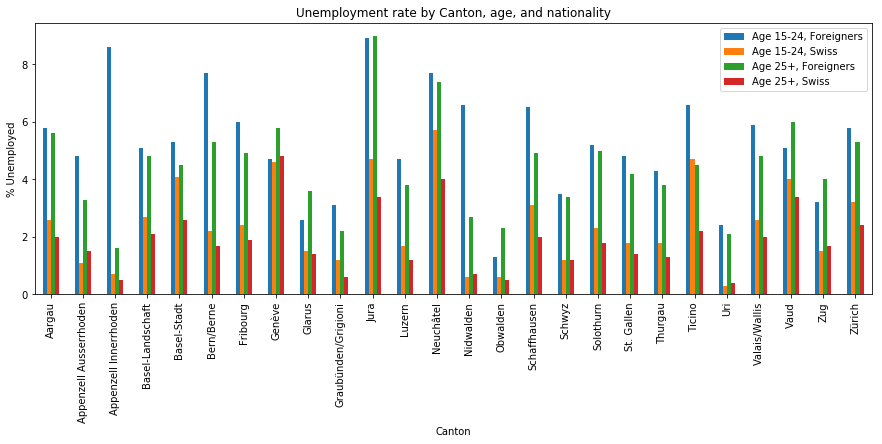

In [109]:
ax = ch_unemploy_rate_canton_nationality_age.unstack().unstack().plot.bar(figsize=(15, 5), stacked=False)
ax.legend(['Age 15-24, Foreigners', 'Age 15-24, Swiss', 'Age 25+, Foreigners', 'Age 25+, Swiss'])
ax.set_ylabel('% Unemployed')
_ = ax.set_title('Unemployment rate by Canton, age, and nationality')

- **Question 4** (BONUS): using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

*"Röstigraben is a humorous term used to refer to the cultural boundary between German-speaking and French-speaking parts of Switzerland"* -- Wikipedia

![](https://upload.wikimedia.org/wikipedia/commons/9/9f/Map_Languages_CH.png)
According to the map above, the French-speaking cantons are: Valais, Fribourg, Genève, Vaud, Neuchâtel, Jura. The German-speaking cantons are all the others except Ticino.

In [116]:
french_speaking = set(['Valais', 'Fribourg', 'Genève', 'Vaud', 'Neuchâtel', 'Jura'])
italian_speaking = set(['Ticino'])
german_speaking = set(ch_unemployed['Canton']) - french_speaking - italian_speaking
print('German-speaking cantons:')
german_speaking

German-speaking cantons:


{'Aargau',
 'Appenzell Ausserrhoden',
 'Appenzell Innerrhoden',
 'Basel-Landschaft',
 'Basel-Stadt',
 'Bern/Berne',
 'Glarus',
 'Graubünden/Grigioni',
 'Luzern',
 'Nidwalden',
 'Obwalden',
 'Schaffhausen',
 'Schwyz',
 'Solothurn',
 'St. Gallen',
 'Thurgau',
 'Uri',
 'Valais/Wallis',
 'Zug',
 'Zürich'}

In [128]:
def get_language(canton):
    if canton in french_speaking:
        return "French"
    elif canton in german_speaking:
        return "German"
    else:
        return "Italian"
    
ch_unemployed['Language'] = ch_unemployed['Canton'].map(get_language)
by_language = ch_unemployed.groupby('Language')['Unemployed Jobseekers', 'Active Population'].sum()
by_language['Unemployment rate (%)'] = by_language['Unemployed Jobseekers']/by_language['Active Population']*100
by_language

,Unemployed Jobseekers,Active Population,Unemployment rate (%)
Language,,,
French,40212,925163,4.346477
German,87755,3420727,2.565390
Italian,5202,166025,3.133263


It appears that German-speaking Cantons have the lowest unemployment rate, and French-speaking Cantons the highest. Here, we also evaluated the *Polentagraben*, which refers to the difference between Italian-speaking Cantons (i.e. Ticino) and the others.